## EXP 2 - SVM

### Import các thư viện cần thiết và tải lên các file dữ liệu

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, log_loss
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed để đảm bảo kết quả có thể tái lập
RANDOM_STATE = 42

In [2]:
train_exp2 = pd.read_csv('../../data/exp2/train_exp2.csv')
test_exp2 = pd.read_csv('../../data/exp2/test_exp2.csv')

### Chuẩn bị features và target

In [3]:
# Lấy cột target (Class)
y_train = train_exp2['Class']

# Loại bỏ các cột không phải là feature
X_train = train_exp2.drop(['Class', 'Id', 'Artist Name', 'Track Name'], axis=1, errors='ignore')
X_test = test_exp2.drop(['Id', 'Artist Name', 'Track Name'], axis=1, errors='ignore')

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (14396, 31)
y_train shape: (14396,)
X_test shape: (3600, 31)


### Phân phối của target

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

X_train_scaled shape: (14396, 31)
X_test_scaled shape: (3600, 31)


### Huấn luyện mô hình

In [5]:
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    random_state=RANDOM_STATE,
    verbose=True
)
# Huấn luyện mô hình
svm_model.fit(X_train_scaled, y_train)

[LibSVM]

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,True


### Đánh giá mô hình

In [6]:
# Dự đoán
y_train_pred_svm = svm_model.predict(X_train_scaled)

# Tính metrics
train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
train_f1_svm = f1_score(y_train, y_train_pred_svm, average='weighted')

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_f1_scores_svm = cross_val_score(svm_model, X_train_scaled, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)
cv_accuracy_scores_svm = cross_val_score(svm_model, X_train_scaled, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

print(f"Độ chính xác tập train: {train_accuracy_svm:.4f}")
print(f"F1-Score tập train: {train_f1_svm:.4f}")
print(f"F1-Score CV: {cv_f1_scores_svm.mean():.4f} (±{cv_f1_scores_svm.std() * 2:.4f})")
print(f"Accuracy CV: {cv_accuracy_scores_svm.mean():.4f} (±{cv_accuracy_scores_svm.std() * 2:.4f})")

Độ chính xác tập train: 0.6305
F1-Score tập train: 0.6060
F1-Score CV: 0.5488 (±0.0046)
Accuracy CV: 0.5739 (±0.0037)


### Phân tích các đặc trưng quan trọng

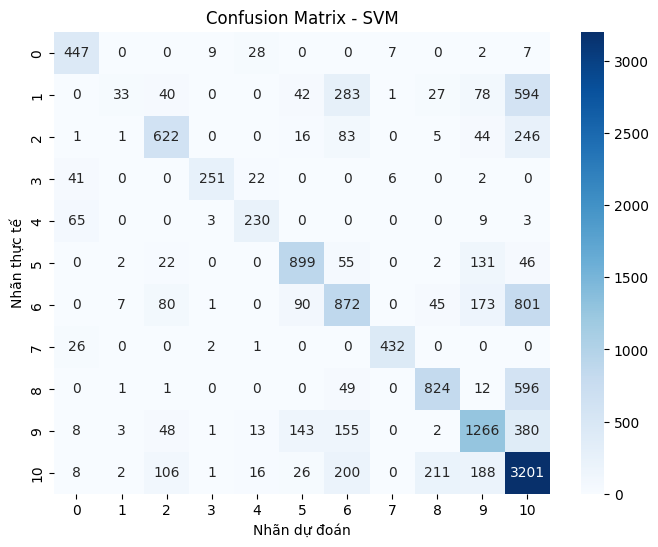

In [7]:
# Tính toán dự đoán nếu chưa có
if 'y_train_pred_svm' not in locals():
    y_train_pred_svm = svm_model.predict(X_train_scaled)

# Vẽ ma trận 
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_train, y_train_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.ylabel('Nhãn thực tế')
plt.xlabel('Nhãn dự đoán')
plt.show()

### Dự đoán trên tập test & đánh giá và lưu kết quả

In [8]:
# Dự đoán trên tập test
y_test_pred_svm = svm_model.predict(X_test_scaled)

# Tạo DataFrame để lưu kết quả
results_df = pd.DataFrame({
    'Id': test_exp2['Id'],
    'Class': y_test_pred_svm
})

# Lưu kết quả ra file CSV
results_path = 'results/SVM_submission.csv'
results_df.to_csv(results_path, index=False)

print(f"Đã lưu kết quả dự đoán vào: {results_path}")
print(f"Số lượng mẫu dự đoán: {len(y_test_pred_svm)}")

Đã lưu kết quả dự đoán vào: results/SVM_submission.csv
Số lượng mẫu dự đoán: 3600


### Tổng quan hoá bằng biểu đồ

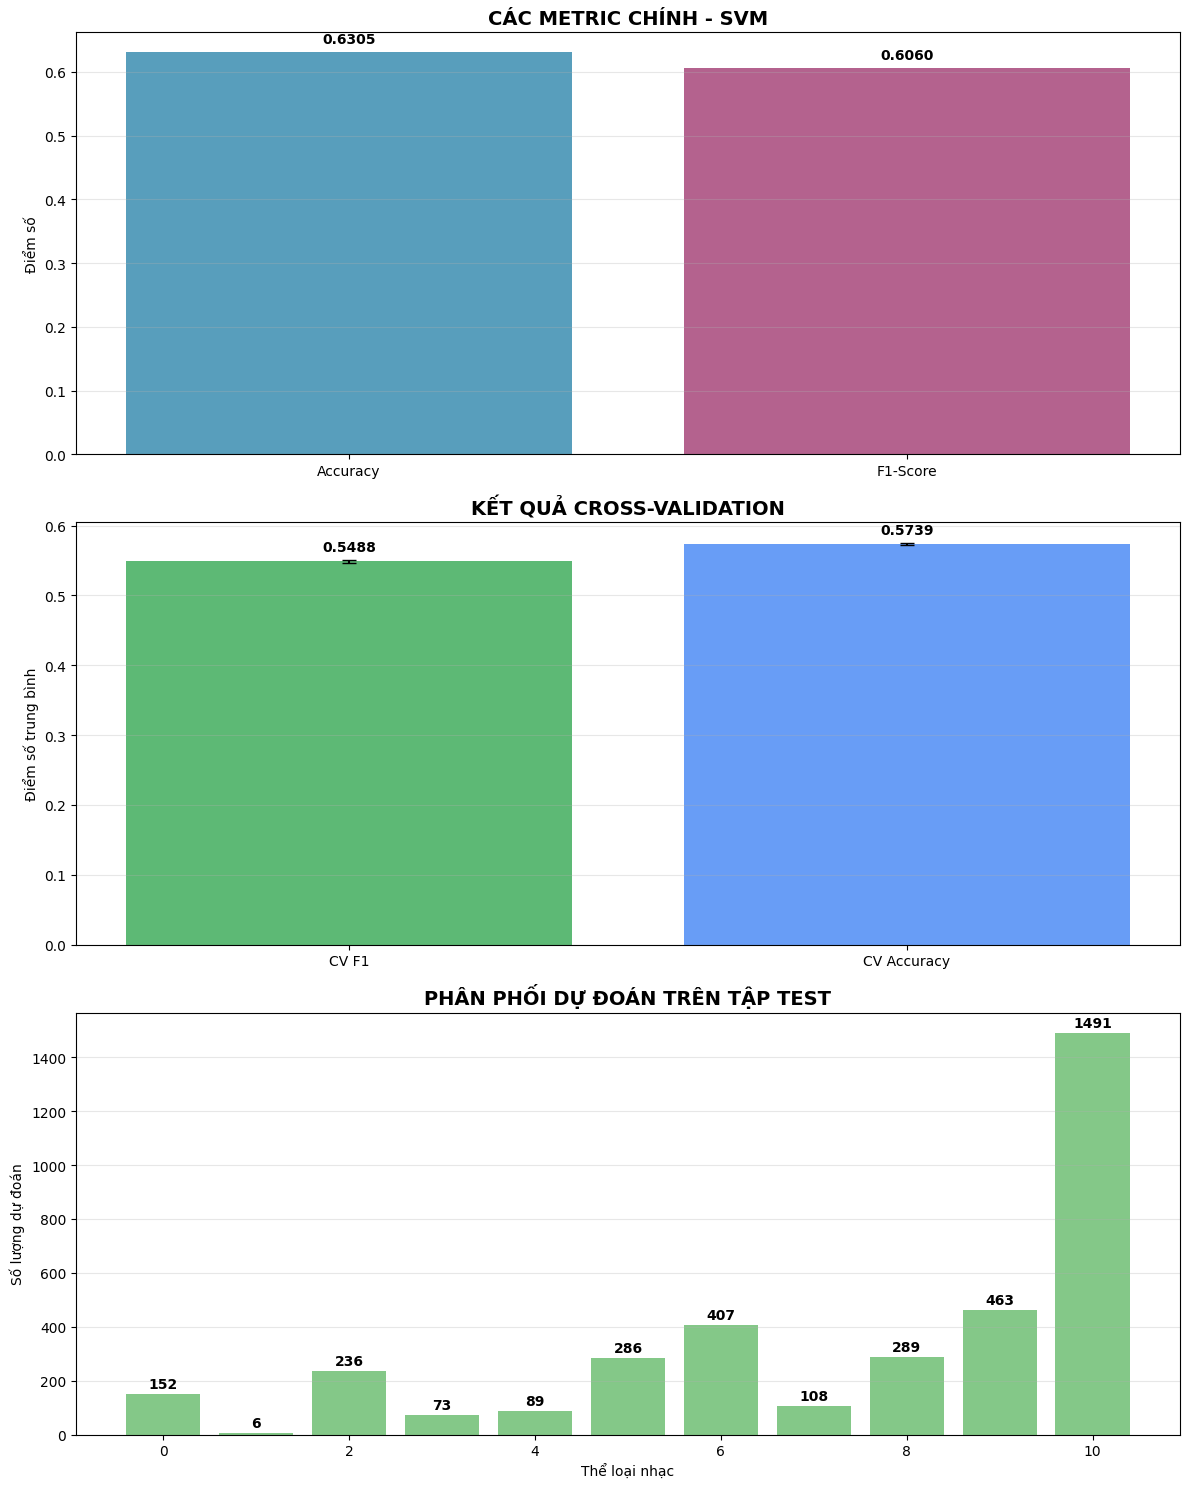

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# 1. Biểu đồ metrics chính
metrics_svm = ['Accuracy', 'F1-Score']
values_svm = [train_accuracy_svm, train_f1_svm]
colors_svm = ['#2E86AB', '#A23B72']

bars_svm = axes[0].bar(metrics_svm, values_svm, color=colors_svm, alpha=0.8)
axes[0].set_title('CÁC METRIC CHÍNH - SVM', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Điểm số')
axes[0].grid(axis='y', alpha=0.3)

for bar, value in zip(bars_svm, values_svm):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. Biểu đồ cross-validation
cv_metrics_svm = ['CV F1', 'CV Accuracy']
cv_means_svm = [cv_f1_scores_svm.mean(), cv_accuracy_scores_svm.mean()]
cv_stds_svm = [cv_f1_scores_svm.std(), cv_accuracy_scores_svm.std()]

bars_cv_svm = axes[1].bar(cv_metrics_svm, cv_means_svm, yerr=cv_stds_svm, capsize=5, 
                         color=['#34A853', '#4285F4'], alpha=0.8)
axes[1].set_title('KẾT QUẢ CROSS-VALIDATION', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Điểm số trung bình')
axes[1].grid(axis='y', alpha=0.3)

for bar, value in zip(bars_cv_svm, cv_means_svm):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# 3. Biểu đồ phân phối dự đoán - SỬA LỖI Ở ĐÂY
# Dự đoán trên tập test nếu chưa có
if 'y_test_pred_svm' not in locals():
    y_test_pred_svm = svm_model.predict(X_test_scaled)

pred_distribution_svm = pd.Series(y_test_pred_svm).value_counts().sort_index()
axes[2].bar(pred_distribution_svm.index, pred_distribution_svm.values, color='#66BB6A', alpha=0.8)
axes[2].set_title('PHÂN PHỐI DỰ ĐOÁN TRÊN TẬP TEST', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Thể loại nhạc')
axes[2].set_ylabel('Số lượng dự đoán')
axes[2].grid(axis='y', alpha=0.3)

# Thêm nhãn số lượng lên các cột
for i, value in enumerate(pred_distribution_svm.values):
    axes[2].text(pred_distribution_svm.index[i], value + 10, str(value), 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()